# Heat Conduction with Latent Heat

Loading and configuring the modules:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from deepxde.backend import tf
%matplotlib inline
import deepxde as dde
import seaborn as sns
sns.set_context("talk")
dde.config.set_default_float("float64")
dde.config.set_random_seed(123456789)

Using backend: tensorflow.compat.v1

2023-03-20 11:50:48.450097: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Instructions for updating:
non-resource variables are not supported in the long term
Enable just-in-time compilation with XLA.



2023-03-20 11:50:50.963476: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-03-20 11:50:50.964463: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-03-20 11:50:51.030904: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:43:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2023-03-20 11:50:51.030950: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-03-20 11:50:51.033411: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-03-20 11:50:51.033467: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.





Set the default float type to float64


## Geometry

Setting up a cubiod as domain:

In [2]:
x_max = 1e-3
y_max = 0.23e-3
z_max = 0.1e-3

geo = dde.geometry.Hypercube((0.0, 0.0, 0.0), (x_max, y_max, z_max))

Adding the time dimension:

In [3]:
t_max = 0.002

time = dde.geometry.TimeDomain(0, t_max)
domain = dde.geometry.GeometryXTime(geo, time)

## Parameter

including the latent heat H

In [4]:
A = 0.09
D = 140e-6
R = D/2
P = 250
v = 200e-3
T_0 = 273.15
T_s = 1693
T_l = 1733
H = 272.0e3

Plot of the mushy zone used in the thesis:

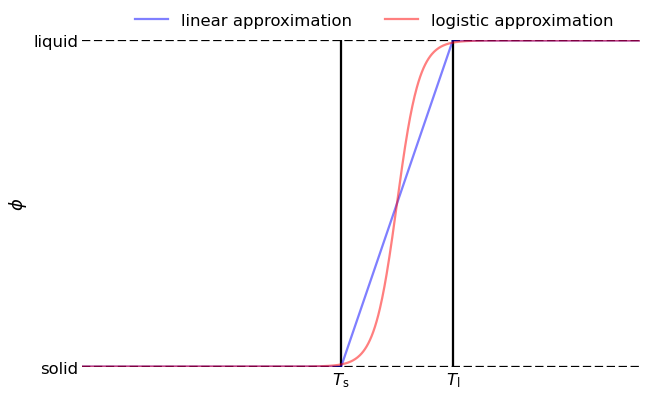

In [5]:
def fermi_np(T):
    return 1/(np.exp((-T+(T_s + T_l)/2)/4)+1)

fig, ax = plt.subplots(figsize=(10, 6))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

T_test = np.linspace(1600, 1800, 1000)

porosity = (T_test-T_s)/(T_l-T_s)
porosity = np.where(T_test>T_s, porosity, porosity*0)
porosity = np.where(T_test>T_l, porosity**0, porosity)

ax.vlines([T_s, T_l], -0.1, 1.1, color = 'black')
ax.hlines([0, 1], T_test.min(), T_test.max(), color = 'black', linestyle='--')
ax.plot(T_test, porosity, color = 'blue', label = 'linear approximation', alpha=0.5)
ax.plot(T_test, fermi_np(T_test), label = 'logistic approximation', color='red', alpha=0.5)

ax.set_xticks([T_s, T_l], [r'$T_\mathrm{s}$',r'$T_\mathrm{l}$'])
ax.set_ylabel(r'$\phi$')
ax.set_yticks([0, 1], ['solid', 'liquid'])
ax.legend(bbox_to_anchor=(0.98,1.13), ncol=2, frameon=False)
ax.set_xlim((T_test.min(), T_test.max()))
ax.set_ylim((0, 1))
ax.tick_params(axis=u'both', which=u'both',length=0)
plt.savefig('fermi.pdf', bbox_inches='tight')

Function for the logistic approximation:

In [6]:
def fermi(T):
    return 1/(tf.exp((-T+(T_s + T_l)/2)/4)+1)

## PDE

Setting up the loss for the heat equation with temperature dependent material parameters:

In [7]:
def pde_system(X, output):
    
    T = output
       
    k = (11.82+1.06e-2*T)
    c = (330.9+0.563*T-4.015e-4*T**2+9.465e-8*T**3)
    rho = 7800.0*T**0
    
    k_powder = 0.6*k
    rho_powder = 0.6*rho
    
    #porosity = (T-T_s)/(T_l-T_s)
    #porosity = tf.where(T>=T_s, porosity, T*0.0)
    #porosity = tf.where(T>=T_l, T**0, porosity)
    
    porosity = fermi(T)
    #k_eff = porosity*k + (1-porosity)*k_powder
    #rho_eff = porosity*rho + (1-porosity)*rho_powder
    k_eff = k_powder
    rho_eff = rho_powder
    
    dT_dx = dde.grad.jacobian(T, X, j = 0)
    dT_dy = dde.grad.jacobian(T, X, j = 1)
    dT_dz = dde.grad.jacobian(T, X, j = 2)
    
    dT_dt = dde.grad.jacobian(T, X, j = 3)
    
    diff_T = (dde.grad.jacobian(k_eff*dT_dx, X, j = 0) + dde.grad.jacobian(k_eff*dT_dy, X, j=1) + dde.grad.jacobian(k_eff*dT_dz, X, j = 2))
    
    f_T = rho_eff*c*dT_dt - diff_T - rho_eff*H*dde.grad.jacobian(porosity, X, j = 3)# + 272e3/(c**2*rho)*tf.cast(molten, 'float64')
        
    return f_T

## Boundary condition

Introducing a Gaussian laser beam profile as Robin bpundary condition:

In [8]:
def top_bc(X, Y):
    
    r_sq = (X[:,0:1] - x_max/4 - X[:,3:4]*v)**2 + (X[:,1:2] - y_max/2)**2
    k = (11.82+1.06e-2*Y)
    k_powder = 0.6*k
    return 2*A*P/(np.pi*R**2)*tf.exp(-2*r_sq/R**2)/k_powder

top = dde.icbc.RobinBC(domain, lambda X, Y : top_bc(X, Y), lambda x, on_boundary: on_boundary)

## Sampling on the boundary

Sampling points on the upper surface of the domain as training data set for the boundary condition:

In [9]:
geo_bound = dde.geometry.Hypercube((0.01*x_max, 0.01*y_max), (0.99*x_max, 0.99*y_max))
domain_bound = dde.geometry.GeometryXTime(geo_bound, time)
x_bound, y_bound, t_bound = domain_bound.random_points(200000, random='Hammersley').T

input_bound = np.vstack((x_bound, y_bound, np.ones(len(x_bound))*z_max, t_bound)).T

## Dataset

Creating the traing data object:

In [10]:
data = dde.data.TimePDE(domain,
                       pde_system,
                       ic_bcs = [top],
                       num_domain = 100000,
                       num_initial = 0,
                       num_boundary = 0,
                       train_distribution="Hammersley",
                       num_test = 1e5,
                       anchors=input_bound
)

## Compilation

Setting up the neural network, applying input and output transformation and compiling the model, loading in the network trained without latant heat:

In [11]:
net = dde.nn.FNN([4] + [20] * 6 + [1], "sin", "Glorot normal") 

def feature_transform(X):
    return tf.concat(
        [(X[:, 0:1]/x_max - 0.5), 
         (X[:, 1:2]/y_max - 0.5),
         (X[:, 2:3]/z_max - 0.5),
         (X[:, 3:4]/t_max - 0.5)], axis=1
    )
net.apply_feature_transform(feature_transform)

def modify_output(X, Y):
    x, y, z, t = X[:, 0:1], X[:, 1:2], X[:, 2:3], X[:, 3:4]
    Temperature = Y
    T_new = 20.0 + T_0 + tf.abs(Temperature*5e25*x*y*(x-x_max)*(y-y_max)*t*z)
    return tf.concat(T_new, axis = 1)
net.apply_output_transform(modify_output)

model = dde.Model(data, net)
model.compile("adam", lr=1e-5)
losshistory, train_state = model.train(epochs=1, display_every=1000)
model.restore('final/-5228.ckpt', verbose=1)
weights = 1/np.array(losshistory.loss_train[0])

Compiling model...
Building feed-forward neural network...
'build' took 0.127015 s



/home/sc.uni-leipzig.de/nl220wxeo/.conda/envs/dde/lib/python3.9/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/home/sc.uni-leipzig.de/nl220wxeo/.conda/envs/dde/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
2023-03-20 11:50:57.040297: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-20 11:

'compile' took 11.223164 s

Initializing variables...


2023-03-20 11:51:08.370396: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:196] None of the MLIR optimization passes are enabled (registered 0 passes)
2023-03-20 11:51:08.673782: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000074999 Hz


Training model...



2023-03-20 11:51:10.008968: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x14ca7c08dcb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-20 11:51:10.009023: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-03-20 11:51:10.668577: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-03-20 11:51:14.238086: I tensorflow/compiler/jit/xla_compilation_cache.cc:333] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Step      Train loss              Test loss               Test metric
0         [9.76e+25, 7.87e+14]    [1.80e+26, 7.87e+14]    []  


2023-03-20 11:51:50.838352: W tensorflow/core/common_runtime/bfc_allocator.cc:433] Allocator (GPU_0_bfc) ran out of memory trying to allocate 10.18GiB (rounded to 10930415872)requested by op cluster_2_1/xla_run
Current allocation summary follows.
2023-03-20 11:51:50.838404: I tensorflow/core/common_runtime/bfc_allocator.cc:972] BFCAllocator dump for GPU_0_bfc
2023-03-20 11:51:50.838422: I tensorflow/core/common_runtime/bfc_allocator.cc:979] Bin (256): 	Total Chunks: 86, Chunks in use: 86. 21.5KiB allocated for chunks. 21.5KiB in use in bin. 5.9KiB client-requested in use in bin.
2023-03-20 11:51:50.838436: I tensorflow/core/common_runtime/bfc_allocator.cc:979] Bin (512): 	Total Chunks: 5, Chunks in use: 5. 3.8KiB allocated for chunks. 3.8KiB in use in bin. 3.1KiB client-requested in use in bin.
2023-03-20 11:51:50.838450: I tensorflow/core/common_runtime/bfc_allocator.cc:979] Bin (1024): 	Total Chunks: 1, Chunks in use: 1. 1.2KiB allocated for chunks. 1.2KiB in use in bin. 1.0KiB clien

ResourceExhaustedError: Out of memory while trying to allocate 10930415752 bytes.
	 [[{{node cluster_2_1/xla_run}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


## Training

In [14]:
weights_2 = np.array([1, 1e2])
model.compile('adam', lr = 1e-5, loss_weights=weights*weights_2)
losshistory, train_state = model.train(iterations = 1000, display_every=100)

Compiling model...
'compile' took 11.851148 s



2023-02-09 11:05:16.433705: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1642] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-line flag, not via TF_XLA_FLAGS) or set the envvar XLA_FLAGS=--xla_hlo_profile.


Training model...

Step      Train loss              Test loss               Test metric
1         [3.56e-01, 5.50e-02]    [1.21e-01, 5.50e-02]    []  
100       [1.48e-01, 6.53e-02]    [7.19e-02, 6.53e-02]    []  
200       [1.37e-01, 5.71e-02]    [5.91e-02, 5.71e-02]    []  
300       [1.31e-01, 5.46e-02]    [5.45e-02, 5.46e-02]    []  
400       [1.30e-01, 5.42e-02]    [5.15e-02, 5.42e-02]    []  
500       [1.24e-01, 5.24e-02]    [5.87e-02, 5.24e-02]    []  
600       [1.21e-01, 5.18e-02]    [6.30e-02, 5.18e-02]    []  
700       [1.18e-01, 5.12e-02]    [6.90e-02, 5.12e-02]    []  
800       [1.16e-01, 5.06e-02]    [7.52e-02, 5.06e-02]    []  
900       [1.13e-01, 5.02e-02]    [8.01e-02, 5.02e-02]    []  
1000      [1.11e-01, 5.00e-02]    [8.30e-02, 5.00e-02]    []  
1001      [1.11e-01, 4.99e-02]    [8.35e-02, 4.99e-02]    []  

Best model at step 1001:
  train loss: 1.61e-01
  test loss: 1.33e-01
  test metric: []

'train' took 90.958272 s



## Adaptive resampling

In [15]:
points = domain.random_points(1000000, random='Hammersley')
errs = np.abs(model.predict(points, operator=pde_system))
points_error = points[errs.T[0].argsort()[-100000:]]
data.add_anchors(points_error)

## More training

In [19]:
losshistory, train_state = model.train(display_every=100)

Training model...



2023-02-09 11:33:00.641776: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Step      Train loss              Test loss               Test metric
1003      [2.69e-01, 3.61e-02]    [4.32e-02, 3.61e-02]    []  
1100      [2.00e-01, 4.30e-02]                                
1200      [1.83e-01, 4.12e-02]                                
1300      [1.76e-01, 4.11e-02]                                
1400      [1.72e-01, 3.97e-02]                                
1500      [1.69e-01, 3.80e-02]                                
1600      [1.66e-01, 3.72e-02]                                
1700      [1.63e-01, 3.70e-02]                                
1800      [1.61e-01, 3.65e-02]                                
1900      [1.59e-01, 3.59e-02]                                
2000      [1.59e-01, 3.38e-02]                                
INFO:tensorflow:Optimization terminated with:
  Message: STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
  Objective function value: 0.192284
  Number of iterations: 930
  Number of functions evaluations: 1002
2005      [1.59e-01, 3

## Prost processing the losses

In [20]:
np.save('loss_smooth', np.array(losshistory.loss_test))

In [21]:
np.save('loss_train_smooth', np.array(losshistory.loss_train))

In [22]:
np.save('loss_sharp', np.array(losshistory.loss_test))

In [21]:
np.save('loss_train_sharp', np.array(losshistory.loss_train))

In [21]:
np.save('loss_smooth_no_pretrain', np.array(losshistory.loss_test))

In [22]:
np.save('loss_train_smooth_no_pretrain', np.array(losshistory.loss_train))

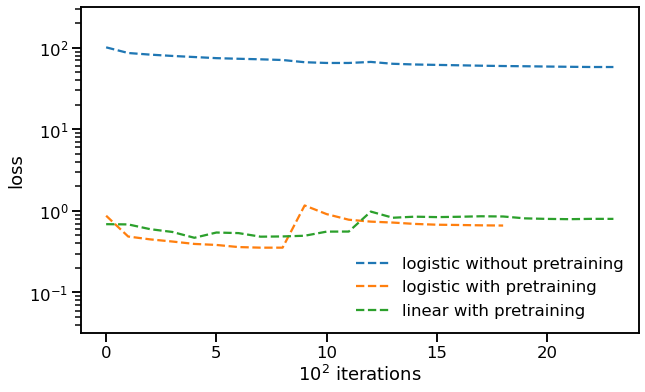

In [15]:
fix, ax = plt.subplots(figsize = (10, 6))

sharp_loss_train = np.load('loss_train_sharp.npy')
smooth_loss_train = np.load('loss_train_smooth.npy')
smooth_loss_train_no_pretrain = np.load('loss_train_smooth_no_pretrain.npy')

ax.set_yscale('log')
ax.plot(smooth_loss_train_no_pretrain.T[0][2:] + smooth_loss_train_no_pretrain.T[1][2:], label = 'logistic without pretraining', linestyle = '--')
ax.plot((smooth_loss_train.T[0][2:] + smooth_loss_train.T[1][2:]), label = 'logistic with pretraining', linestyle = '--')
ax.plot((sharp_loss_train.T[0][2:] + sharp_loss_train.T[1][2:]), label = 'linear with pretraining', linestyle = '--')

#plt.plot(smooth_loss_train_no_pretrain.T[0][2:], label = 'logistic without pretraining', linestyle = '--')
#plt.plot(smooth_loss_train.T[0][2:], label = 'logistic with pretraining', linestyle = '--')
#plt.plot(sharp_loss_train.T[0][2:], label = 'linear with pretraining', linestyle = '--')

ax.set_xlabel(r'$10^2$ iterations')
ax.set_ylabel(r'loss')

ax.set_ylim([10**-1.5, 10**2.5])
ax.legend(loc = 'lower right', frameon=False)
plt.savefig('losses_latent.pdf', bbox_inches='tight')

## Model saving

In [27]:
model.save('latent/sharp')

INFO:tensorflow:latent/sharp-2001.ckpt is not in all_model_checkpoint_paths. Manually adding it.


'latent/sharp-2001.ckpt'

In [30]:
model.save('latent/final')

INFO:tensorflow:latent/final-2001.ckpt is not in all_model_checkpoint_paths. Manually adding it.


'latent/final-2001.ckpt'

## Testing the influence of $C$

INFO:tensorflow:Restoring parameters from latent/sharp-2001.ckpt
INFO:tensorflow:Restoring parameters from latent/final-2001.ckpt


Text(0.5, 0, 'C')

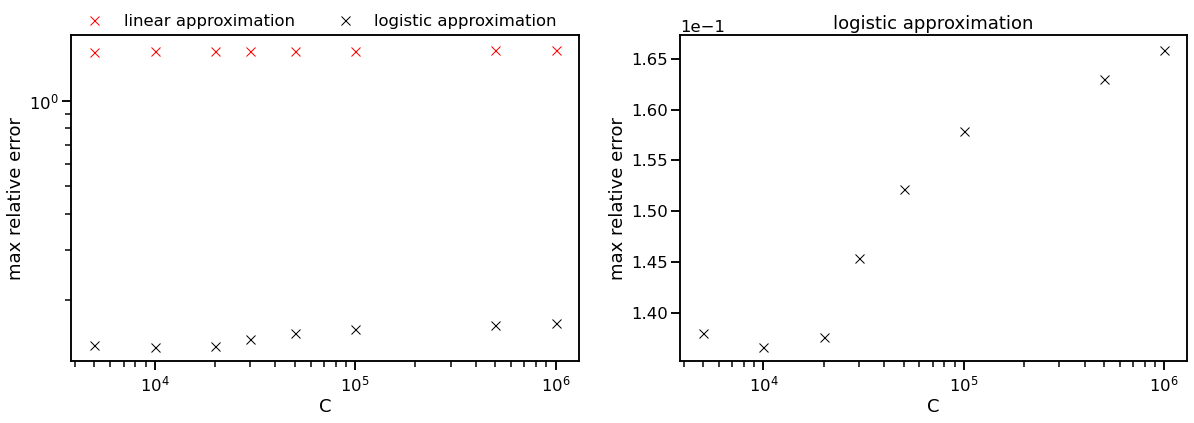

In [13]:
model.restore('latent/sharp-2001.ckpt')

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (20, 6))

ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.set_xscale('log')

for name, C in zip(['5e3', '1e4', '2e4', '3e4', '5e4', '1e5', '5e5', '1e6'], [5e3, 1e4, 2e4, 3e4, 5e4, 1e5, 5e5, 1e6]):
    end_data = np.genfromtxt('latent_heat/{}.csv'.format(name), delimiter = ',',skip_header = True)

    x, y, z, T = end_data[:, 0], end_data[:, 1], end_data[:, 2], end_data[:, 3]

    xi = np.linspace(x.min(), x.max(), 100)
    yi = np.linspace(y.min(), y.max(), 100)

    X = np.vstack((x, y, np.ones(len(x))*z.max(), np.ones(len(x))*t_max)).T
    Y = model.predict(X)
   # plt.plot(C, np.max(np.abs(T - Y[:,0])), 'kx')
    ax1.plot(C, np.max(np.abs(T - Y[:,0])/T), 'rx', label = (C==5e3)*'linear approximation')

model.restore('latent/final-2001.ckpt')
    
for name, C in zip(['5e3', '1e4', '2e4', '3e4', '5e4', '1e5', '5e5', '1e6'], [5e3, 1e4, 2e4, 3e4, 5e4, 1e5, 5e5, 1e6]):
    end_data = np.genfromtxt('latent_heat/{}.csv'.format(name), delimiter = ',',skip_header = True)

    x, y, z, T = end_data[:, 0], end_data[:, 1], end_data[:, 2], end_data[:, 3]

    xi = np.linspace(x.min(), x.max(), 100)
    yi = np.linspace(y.min(), y.max(), 100)

    X = np.vstack((x, y, np.ones(len(x))*z.max(), np.ones(len(x))*t_max)).T
    Y = model.predict(X)
   # plt.plot(C, np.max(np.abs(T - Y[:,0])), 'kx')
    ax1.plot(C, np.max(np.abs(T - Y[:,0])/T), 'kx', label = (C==5e3)*'logistic approximation')
    ax2.plot(C, np.max(np.abs(T - Y[:,0])/T), 'kx', label = (C==5e3)*'logistic approximation')

ax2.ticklabel_format(style='sci',  scilimits=(0, 0), axis='y')
ax2.set_title('logistic approximation')
ax1.legend(frameon=False, loc = (0, 1), ncol=2)
ax1.set_ylabel('max relative error')
ax2.set_ylabel('max relative error')
ax1.set_xlabel('C')
ax2.set_xlabel('C')

plt.savefig('errors_latent.pdf', bbox_inches='tight')

## Temperature fields

INFO:tensorflow:Restoring parameters from latent/final-2001.ckpt


2023-03-10 18:25:56.331144: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


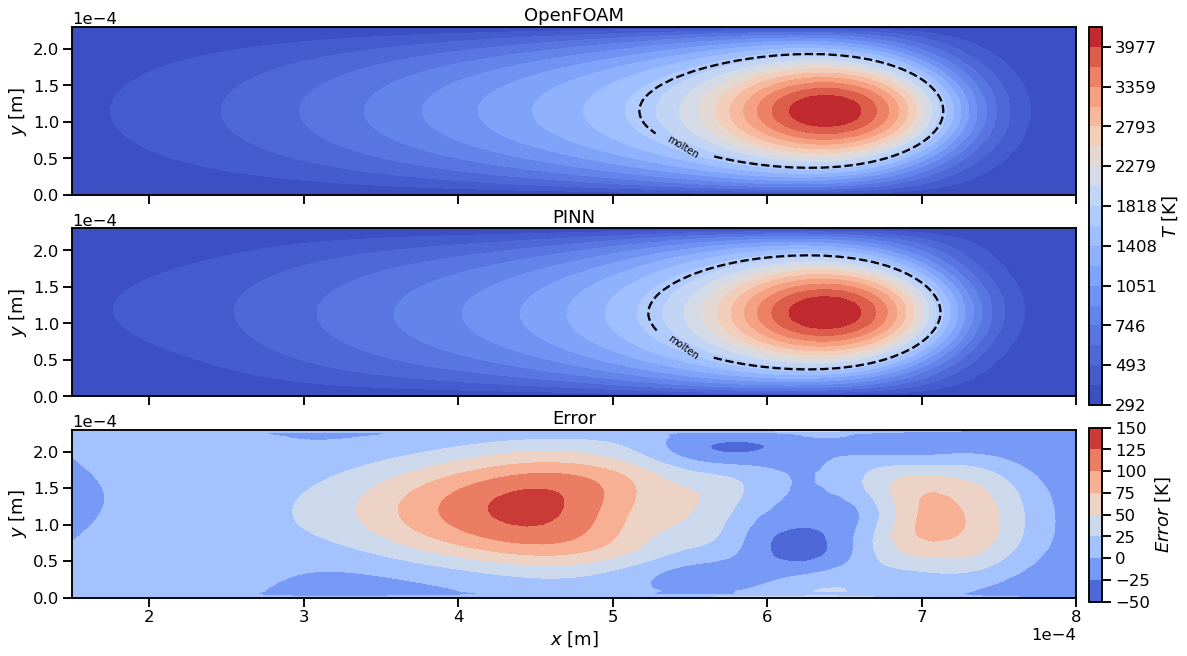

In [14]:
%matplotlib inline
#model.restore('latent/sharp-2001.ckpt')
model.restore('latent/final-2001.ckpt')
end_data = np.genfromtxt('latent_heat/1e4.csv', delimiter = ',',skip_header = True)

x, y, z, T = end_data[:, 0], end_data[:, 1], end_data[:, 2], end_data[:, 3]

xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)

X = np.vstack((x, y, np.ones(len(x))*z.max(), np.ones(len(x))*t_max)).T
Y = model.predict(X)

Ti = griddata((x, y), T, (xi[None,:], yi[:,None]), method='cubic')
T_pred = griddata((x, y), Y[:,0], (xi[None,:], yi[:,None]), method='cubic')

#Plotting

fig, (ax1, ax2, ax3) = plt.subplots(ncols = 1, nrows = 3, figsize = (18, 10.5), sharex=True)

intervals = np.linspace(np.sqrt(T_pred.min()), np.sqrt(T_pred.max()), 20)**2
im = ax1.contourf(xi, yi, Ti, intervals, cmap=plt.cm.coolwarm, vmin = Ti.min(), vmax = Ti.max())
CS = ax2.contourf(xi, yi, T_pred, intervals, cmap=plt.cm.coolwarm, vmin = Ti.min(), vmax = Ti.max())

im2 = ax1.contour(xi, yi, Ti, [1693], linestyles='--', colors='black')
CS2 = ax2.contour(xi, yi, T_pred, [1693], linestyles='--', colors='black')

ax1.clabel(im2, inline=True, fontsize=10, fmt=lambda x : 'molten')
ax2.clabel(CS2, inline=True, fontsize=10, fmt=lambda x : 'molten')

ax1.set_ylabel('$y$ [m]')
ax1.set_title('OpenFOAM')
ax3.set_title('Error')
ax2.set_ylabel('$y$ [m]')
ax3.set_ylabel('$y$ [m]')
ax3.set_xlabel('$x$ [m]')
ax2.set_title('PINN')
ax2.set_xlim([0.00015, 0.0008])
ax1.set_xlim([0.00015, 0.0008])
ax3.set_xlim([0.00015, 0.0008])
ax1.ticklabel_format(style='sci',  scilimits=(0, 0))
ax2.ticklabel_format(style='sci',  scilimits=(0, 0))
ax3.ticklabel_format(style='sci',  scilimits=(0, 0))

#cbar_ax = fig.add_axes([0.91, 0.11, 0.01, 0.77])
cbar_ax = fig.add_axes([0.91, 0.38, 0.01, 0.5])
fig.colorbar(im, cax=cbar_ax)
cbar_ax.set_ylabel('$T$ [K]')

im3 = ax3.contourf(xi, yi, Ti-T_pred, cmap=plt.cm.coolwarm)
#im2 = ax3.contour(xi, yi, Ti, [1693], linestyles='--', colors='black')
#CS2 = ax3.contour(xi, yi, T_pred, [1693], linestyles='--', colors='black')

cbar_ax_2 = fig.add_axes([0.91, 0.12, 0.01, 0.23])
fig.colorbar(im3, cax=cbar_ax_2)
cbar_ax_2.set_ylabel('$Error$ [K]')

plt.savefig('conduct_pics/xy_contour_latent.pdf', bbox_inches='tight')
plt.show()

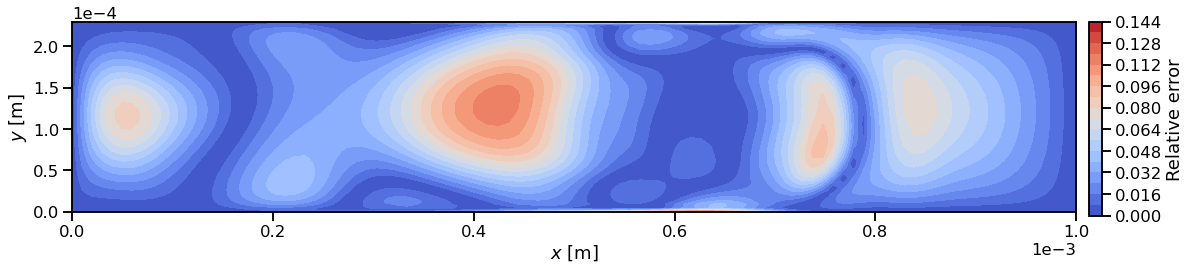

In [20]:
fig, (ax1) = plt.subplots(ncols = 1, nrows = 1, figsize = (18, 3.5))

plt.ylabel('$y$ [m]')
plt.xlabel('$x$ [m]')
plt.ticklabel_format(style='sci',  scilimits=(0, 0))
im = ax1.contourf(xi, yi, np.abs(Ti - T_pred)/Ti, 20, cmap=plt.cm.coolwarm)
cbar_ax = fig.add_axes([0.91, 0.11, 0.01, 0.77])
fig.colorbar(im, cax=cbar_ax, label = 'Relative error')

plt.savefig('conduct_pics/xy-error_latent.pdf', bbox_inches='tight')

## Profiles

INFO:tensorflow:Restoring parameters from final/-5228.ckpt
INFO:tensorflow:Restoring parameters from latent/final-2001.ckpt


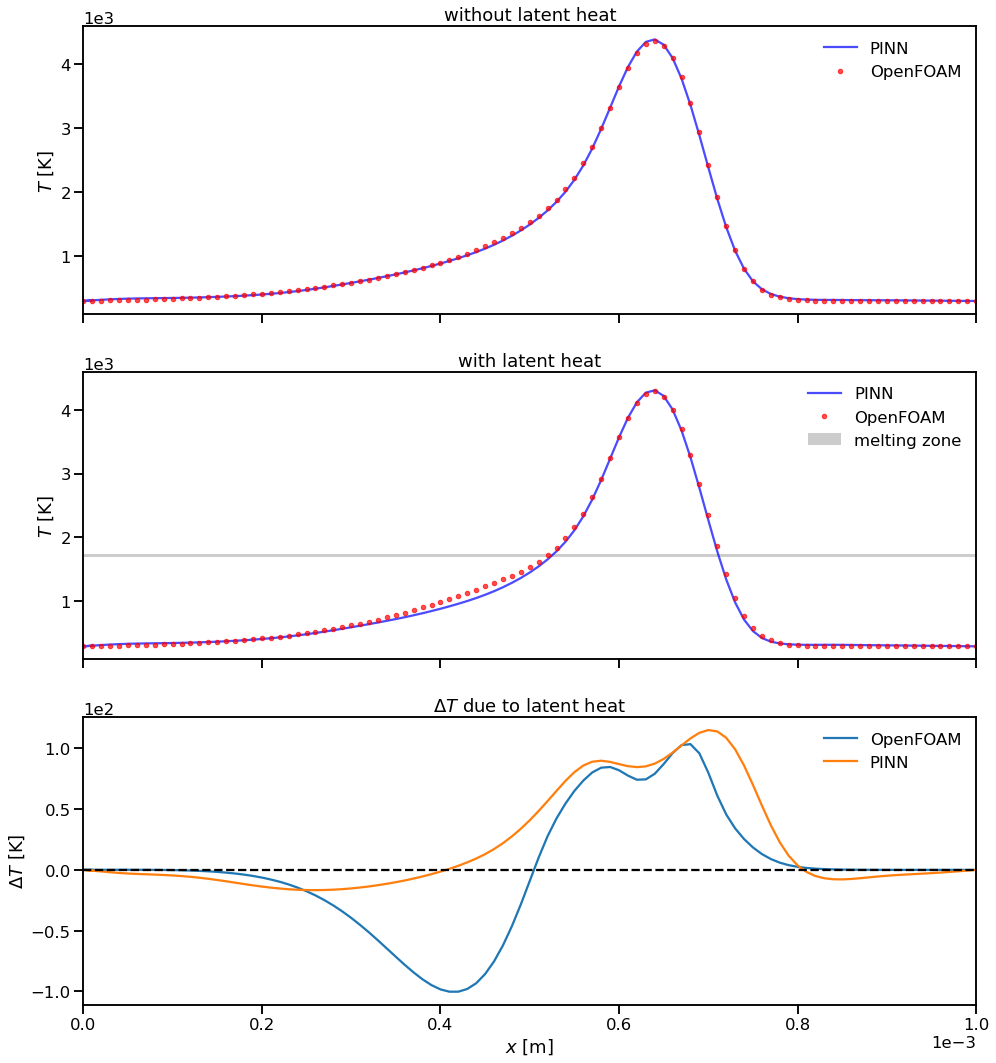

In [16]:
#x_lin = np.linspace(0, x_max, 100)
al_value = 0.7

data_ = np.genfromtxt('latent_heat/no_latent.csv', delimiter = ',',skip_header = True)
x, y, z, T = data_[:, 0], data_[:, 1], data_[:, 2], data_[:, 3]
mask_1 = y == y_max/2
x, y, z, T = x[mask_1], y[mask_1], z[mask_1], T[mask_1]
x_lin = x
y_lin = y_max/2

#y_lin = [y_max/2]
xx, yy, zz, tt = np.meshgrid(x_lin, y_lin, [z_max], [t_max])
X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T

fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, figsize = (16, 18), sharex=True)

#no latent
model.restore('final/-5228.ckpt')
#openfoam
Y = model.predict(X)
ax1.plot(x_lin, Y, 'b-', label = 'PINN', alpha = al_value)

#openfoam
ax1.plot(x, T, 'r.',label='OpenFOAM', alpha = al_value)
ax1.legend(frameon=False, loc = "upper right")
ax1.set_ylabel('$T$ [K]')

#with latent
model.restore('latent/final-2001.ckpt')
#openfoam
Y_2 = model.predict(X)
ax2.plot(x_lin, Y_2,'b-', label = 'PINN', alpha = al_value)
ax2.set_ylabel('$T$ [K]')

#openfoam
data_ = np.genfromtxt('latent_heat/1e4.csv', delimiter = ',',skip_header = True)
x, y, z, T_2 = data_[:, 0], data_[:, 1], data_[:, 2], data_[:, 3]
mask_1 = y == y_max/2
x, y, z, T_2 = x[mask_1], y[mask_1], z[mask_1], T_2[mask_1]
ax2.plot(x, T_2, 'r.',label='OpenFOAM', alpha = al_value)
ax2.fill_between(np.linspace(0, x_max), T_s, T_l, color = 'grey', alpha = 0.4, edgecolor="none", label = 'melting zone')
ax2.legend(frameon=False, loc = "upper right")
ax2.set_xlim((-0*x_max, 1*x_max))

#deviation
ax3.plot(x, (T-T_2), label = 'OpenFOAM')
ax3.plot(x, (Y-Y_2), label = 'PINN')
ax3.set_xlabel('$x$ [m]')
ax3.hlines([0], 0, x_max, color = 'black', linestyle = '--')
ax3.legend(frameon=False)
ax3.set_ylabel('$\Delta T$ [K]')

ax1.ticklabel_format(style='sci',  scilimits=(0, 0))
ax2.ticklabel_format(style='sci',  scilimits=(0, 0))
ax3.ticklabel_format(style='sci',  scilimits=(0, 0))

ax2.set_ylim(ax1.get_ylim())
ax1.set_title('without latent heat')
ax2.set_title('with latent heat')
ax3.set_title('$\Delta T$ due to latent heat')

plt.savefig('profile_latent.pdf', bbox_inches='tight')

## Histogram of the training data

INFO:tensorflow:Restoring parameters from latent/final-2001.ckpt


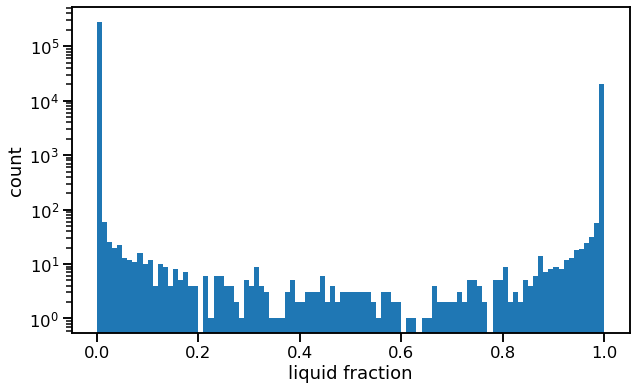

In [18]:
model.restore('latent/final-2001.ckpt')
plt.figure(figsize=(10, 6))
plt.yscale('log')
plt.hist(fermi_np(model.predict(data.train_points())), 100)
plt.xlabel(r'liquid fraction')
plt.ylabel(r'count')

plt.savefig("count.pdf", bbox_inches='tight')